In [83]:
import sys
import json
import time
import string

from tweepy import API
from tweepy import OAuthHandler

from tweepy import Cursor

from tweepy import Stream
from tweepy.streaming import StreamListener

# Accessing Twitter Data
* Authentication
 * Performed using  `Open Authorization (OAuth)` which involves communication between the user, the consumer (app) and the resource provider (Twitter in this case). 
* Data Collection
* Data Cleaning


## API
* REST (Representational State Transfer) APIs 
 * Allow us to read already existing Tweets. Keep in mind that there are limits on har far back in time we can search.
 * Useful for looking at a certain user.
* Streaming APIs
 * Allow us to retrieve all the tweets that have been published since we opened an HTTP connection.
 * useful for listening to a live event.
 
`Tweepy` is a Python client used to implement different types of calls to the desired API.

# Your twitter API keys and tokens  

In order to access Twitter data we need to go to the [Application Management Page](https://apps.twitter.com/) to register your APP.

Your [Keys and Access Tokens](https://dev.twitter.com/oauth/overview) will be available once your app is registered.

For more information look [here](https://dev.twitter.com/).

In [84]:
from config import *

# contents of config.py

# consumer_key    = 'XXXXXXXXXXXXXXXXXXXXX'
# consumer_secret = 'XXXXXXXXXXXXXXXXXXXXX' 
# access_token    = 'XXXXXXXXXXXXXXXXXXXXX'
# access_secret   = 'XXXXXXXXXXXXXXXXXXXXX'

In [85]:
# Authentication
def get_twitter_auth():
    """Setup Twitter Authentication.
    
    Return: tweepy.OAuthHandler object
    """
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return auth
    
def get_twitter_client():
    """Setup Twitter API Client.
    
    Return: tweepy.API object
    """
    auth = get_twitter_auth()
    client = API(auth)
    return client

client = get_twitter_client()

# REST API

## Going through Timelines

In [86]:
time.sleep(900) # sleep for 15 mins.

for i, status in enumerate(Cursor(client.home_timeline).items(5)): 
    print('{0}.)   {1}\n'.format(i+1, status.text))

1.)   RT @TimOfLegend: If you could make a human centipede using only 3-headed dogs, it could be a fun way to teach fractals to kids.

2.)   Trump, Putin, &amp; the hidden history of how Russia interfered in the US Presidential election: https://t.co/BxfjkMDLev #RussiaHacking #Estonia

3.)   I might have to try something like this in my DSP class.

https://t.co/9c3dwVzVe0

4.)   When it comes to #Healthcare, #BigData is a Big Deal: https://t.co/yDg6tdtvwQ #Analytics #HealthIT #DataScience… https://t.co/SdBVKE96Cn

5.)   TV dilemma? #NFCChampionship or #MythBustersSearch testing a classic w/explosives. We've got encores, https://t.co/EmwEYkpkfn &amp; your DVR.



## Getting Tweets

In [90]:
"""If you get: TweepError: Twitter error response: status code = 429
Then you have exceeded your
"""
with open('home_timeline.jsonl','w') as f:
    for page in Cursor(client.home_timeline, count=200).pages(4): # limit of 800 for you
        for status in page:
            f.write(json.dumps(status._json)+'\n')
            
#with open('home_timeline.txt','w') as f:
#    for page in Cursor(client.home_timeline, count=200).pages(4): # limit of 3200 for other user
#        for status in page:
#            f.write(json.dumps(status.text) +'\n')

In [95]:
user = 'kdnuggets'
fname = 'usr_timeline_{}.jsonl'.format(user)
with open(fname, 'w') as f:
    for page in Cursor(client.user_timeline, screen_name=user, count=200).pages(16): # limit of 3200 for other user
        for status in page:
            f.write(json.dumps(status._json)+'\n')

# Streaming API

* `MyListener` is an extension of `tweepy.StreamListener`. 

* This basic implementation overides the two methods `on_data()` and `on_error()`.

* Notice that the return type of the class methods is a Boolean - `True` continues streaming, `False` stops the streaming.

In [111]:
#time.sleep(900) # sleep for 15 mins.

class MyListener(StreamListener):
    """Streaming Twitter Data."""
    
    def __init__(self, fname):
        safe_fname = self.format_filename(fname)
        self.outfile = 'stream_{}.jsonl'.format(safe_fname)
    
    @staticmethod
    def format_filename(fname):
        """Convert fname into safe string for file name.
        
        Return: string
        """
        return ''.join(MyListener.convert_valid(one_char) for one_char in fname)
    
    @staticmethod
    def convert_valid(one_char):
        """Convert invalid characters into '_'
        
        Return: string
        """
        valid_chars = '-_.{0}{1}'.format(string.ascii_letters, string.digits)
        if one_char in valid_chars:
            return one_char
        else:
            return '_'
        
    def on_data(self, data):
        try:
            with open(self.outfile, 'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            sys.stderr.write('Error on_data: {}'.format(e))
            time.sleep(5)
        return True
    
    def on_error(self, status):
        if status==420:
            sys.stderr.write('Rate limit exceeded\n'.format(status))
            return False
        else:
            sys.stderr.write('Error\n'.format(status))
            return True
                

In [124]:
query = ['#Python', '#DataScience']
query_name = ''.join(query)

auth = get_twitter_auth()
twitter_stream = Stream(auth, MyListener(query_name))

twitter_stream.filter(track=query, async=True)

# Visualization

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [136]:
fname = 'stream__Python_DataScience.jsonl'
with open(fname, 'r') as f:
    all_dates = []
    for line in f:
        tweet = json.loads(line)
        all_dates.append(tweet.get('created_at'))
        
    idx = pd.DatetimeIndex(all_dates)
    ones = np.ones(len(all_dates))
    my_series = pd.Series(ones, index=idx)
    per_minute = my_series.resample('1Min').sum().fillna(0)

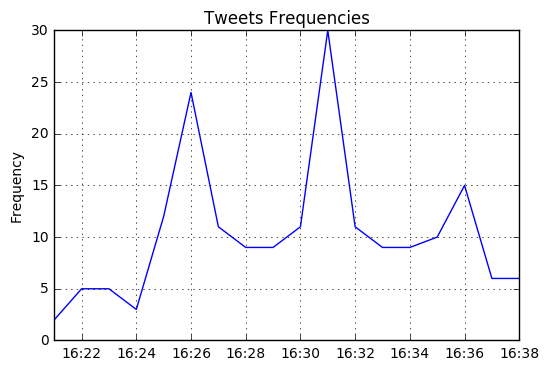

In [145]:
fig, ax = plt.subplots()

ax.plot(per_minute.index, per_minute)

plt.grid(True)
plt.title('Tweets Frequencies')
plt.ylabel('Frequency')

hours = mdates.MinuteLocator(interval=2)
date_formatter = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
max_freq = per_minute.max()
ax.set_ylim(0, max_freq)

plt.show();

# Anatomy of a Tweet

This will come in handy when doing more analysis.

In [87]:
for status in Cursor(client.home_timeline).items(1):
    print(json.dumps(status._json, indent=4))

{
    "retweet_count": 9,
    "id": 820451940912037888,
    "in_reply_to_user_id": null,
    "in_reply_to_screen_name": null,
    "user": {
        "profile_image_url_https": "https://pbs.twimg.com/profile_images/702521133732597760/8b-V29CP_normal.jpg",
        "id": 15840592,
        "profile_image_url": "http://pbs.twimg.com/profile_images/702521133732597760/8b-V29CP_normal.jpg",
        "description": "Wearing 1000 Hats/Minute. Yak Barber. Building None and NOWHERE. Earlier on: Demoscene (Neuro / Farbrausch). Married to @sylvia_ritter and @duangle.   133547455",
        "favourites_count": 72955,
        "follow_request_sent": false,
        "profile_sidebar_border_color": "000000",
        "followers_count": 4614,
        "geo_enabled": false,
        "utc_offset": 3600,
        "default_profile_image": false,
        "profile_sidebar_fill_color": "FFFFFF",
        "profile_text_color": "000000",
        "notifications": false,
        "profile_background_tile": false,
        "pro